In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

In [2]:
#import dataset
spydf = pd.read_csv('/Users/samkohnle/Desktop/Project_2/SPY.csv')
spydf

Date        Open        High         Low       Close   Adj Close  \
0    2021-02-25  390.410004  391.880005  380.779999  382.329987  377.300629   
1    2021-02-26  384.350006  385.579987  378.230011  380.359985  375.356537   
2    2021-03-01  385.589996  390.920013  380.570007  389.579987  384.455292   
3    2021-03-02  389.820007  390.070007  386.000000  386.540009  381.455292   
4    2021-03-03  385.790009  386.829987  381.309998  381.420013  376.402618   
..          ...         ...         ...         ...         ...         ...   
248  2022-02-17  443.220001  446.570007  436.420013  437.059998  437.059998   
249  2022-02-18  437.329987  438.660004  431.820007  434.230011  434.230011   
250  2022-02-22  431.890015  435.500000  425.859985  429.570007  429.570007   
251  2022-02-23  432.660004  433.260010  421.350006  421.950012  421.950012   
252  2022-02-24  411.019989  428.760010  410.640991  428.299988  428.299988   

        Volume  
0    146670500  
1    152701600  
2    105348800  
3     79595300  
4    119940200  
..         ...  
248  102259100  
249  132454300  
250  124391800  
251  132578000  
252  209634022  

[253 rows x 7 columns]

In [3]:
#Total Number of days
print("Total number of days: ",spydf.shape[0])
print("Total number of fields: ",spydf.shape[1])

Total number of days:  253
Total number of fields:  7


In [4]:
#Check for Nulls
print("Null values:", spydf.isnull().values.sum())
print("NA values:", spydf.isna().values.any())

Null values: 0
NA values: False


In [5]:
#change Date from string to datetime format
spydf['Date'] = pd.to_datetime(spydf.Date)
spydf.head()

Date        Open        High         Low       Close   Adj Close  \
0 2021-02-25  390.410004  391.880005  380.779999  382.329987  377.300629   
1 2021-02-26  384.350006  385.579987  378.230011  380.359985  375.356537   
2 2021-03-01  385.589996  390.920013  380.570007  389.579987  384.455292   
3 2021-03-02  389.820007  390.070007  386.000000  386.540009  381.455292   
4 2021-03-03  385.790009  386.829987  381.309998  381.420013  376.402618   

      Volume  
0  146670500  
1  152701600  
2  105348800  
3   79595300  
4  119940200

In [6]:
#Length of Observation
print("Starting date: ",spydf.iloc[0][0])
print("Ending date: ", spydf.iloc[-1][0])
print("Duration: ", spydf.iloc[-1][0]-spydf.iloc[0][0])

Starting date:  2021-02-25 00:00:00
Ending date:  2022-02-24 00:00:00
Duration:  364 days 00:00:00


In [7]:
#Average Month comparision between open and closing price
monthvise= spydf.groupby(spydf['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open       Close
Date                             
January    456.829501  455.847999
February   437.586845  436.665265
March      390.073046  390.286960
April      412.269049  412.910471
May        416.008501  415.976500
June       422.941365  422.984544
July       434.394284  435.094282
August     443.969998  444.520000
September  444.727622  443.553811
October    443.852859  444.725237
November   466.076664  465.755716
December   466.088186  466.405002

In [8]:
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

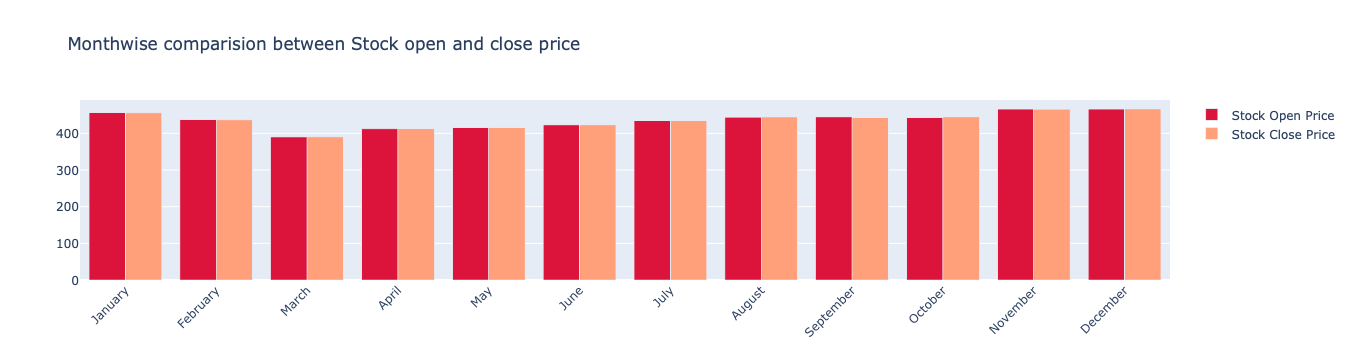

In [9]:
#Bar Chart of Month comparision
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

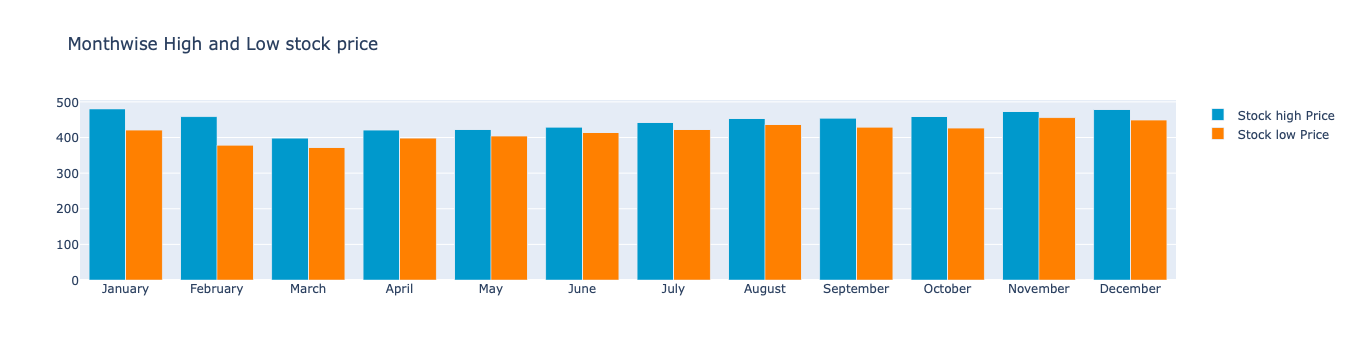

In [10]:
#Monthly High and Lows of Stock Prices
spydf.groupby(spydf['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = spydf.groupby(spydf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = spydf.groupby(spydf['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

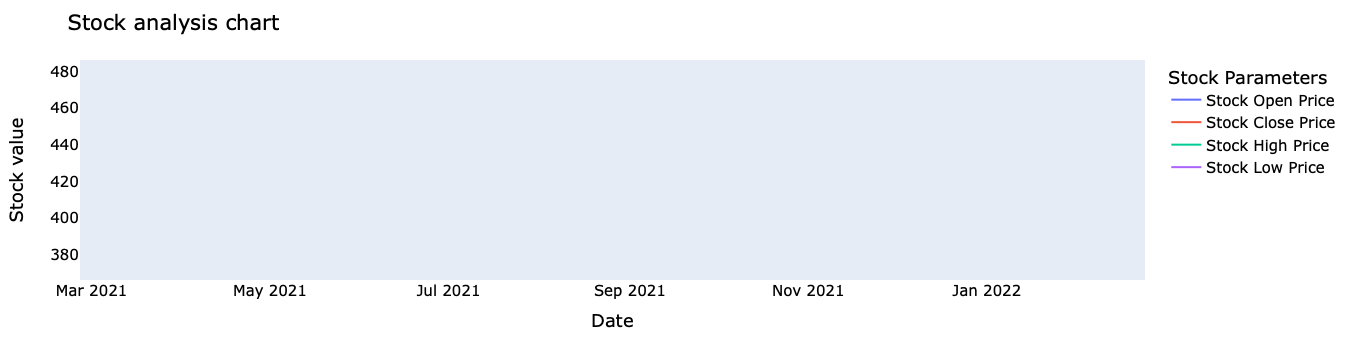

In [12]:
#Trend Comparisons between stock open, close, high, and low prices
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(spydf, x=spydf.Date, y=[spydf['Open'], spydf['Close'], 
                                          spydf['High'], spydf['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [13]:
#Preparing Stock Close Price for Predicition
#Creating seperate dataframe of closing price
closedf = spydf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (253, 2)


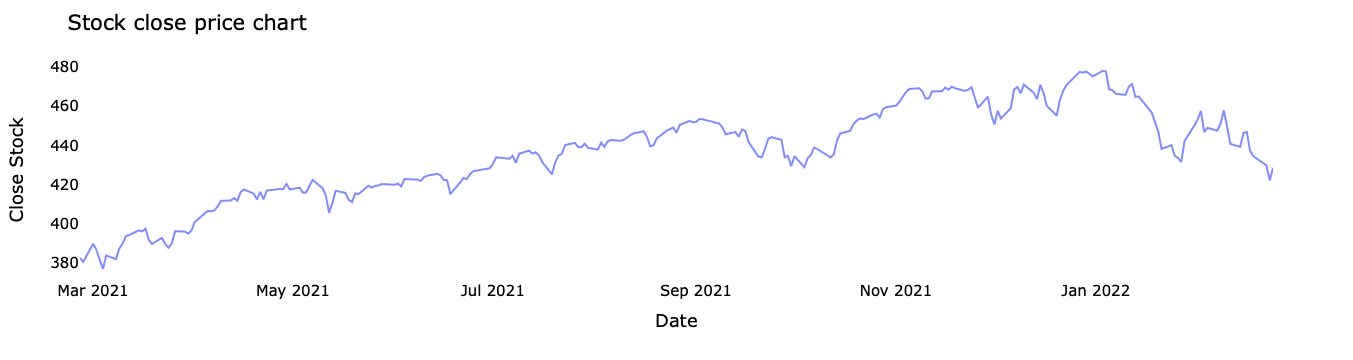

In [14]:
#Graph of stock closing price
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [15]:
#Observing 351 closing prices for prediction
closedf = closedf[closedf['Date'] > '2020-08-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  253


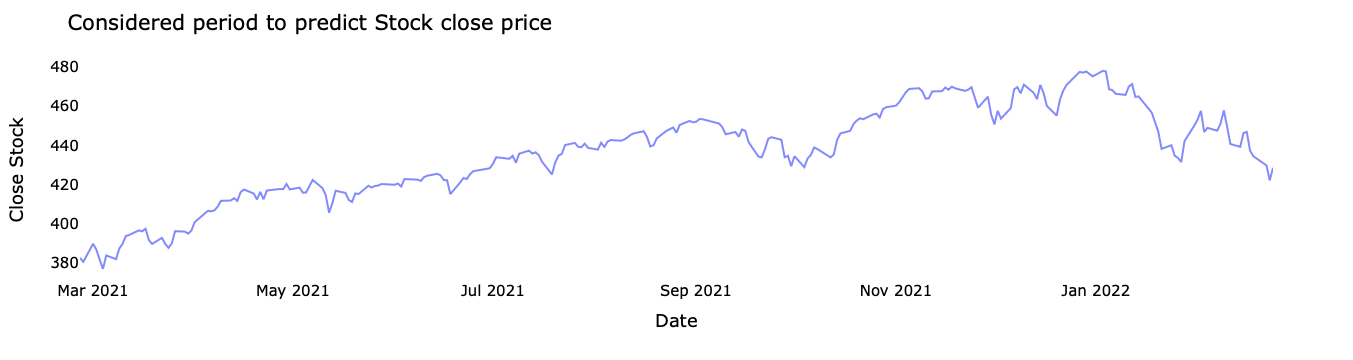

In [16]:
#Graph of 351 Observed Data Points
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [17]:
#Normalizing and Fitting Close Price
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(253, 1)


In [18]:
#Prepating Data for train and Test
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (151, 1)
test_data:  (102, 1)


In [19]:
#Transforming Close Price for Time-Series Analysis
#Converting values into a dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (140, 10)
y_train:  (140,)
X_test:  (91, 10)
y_test (91,)


In [21]:
#reshaping the inputs
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (140, 10, 1)
X_test:  (91, 10, 1)


In [22]:
#Model Building GRU
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2022-02-26 10:03:30.808249: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 6s 406ms/step - loss: 0.2151 - val_loss: 0.3845
Epoch 2/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0982 - val_loss: 0.1235
Epoch 3/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0179 - val_loss: 0.0142
Epoch 4/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0286 - val_loss: 0.0108
Epoch 5/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0121 - val_loss: 0.0413
Epoch 6/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0621
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0399
Epoch 8/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0097 - val_loss: 0.0175
Epoch 9/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 10/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0172
Epoch 11/200
5/5 [

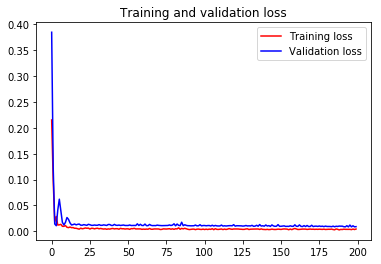

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting Loss Chart
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((140, 1), (91, 1))

In [27]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [28]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.56734065169038
Train data MSE:  20.8606006285835
Train data MAE:  3.594558321233258
-------------------------------------------------------------------------------------
Test data RMSE:  9.601575135971176
Test data MSE:  92.1902450916999
Test data MAE:  8.223367889830872


In [29]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9275731921234969
Test data explained variance regression score: 0.450071458488135


In [30]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9275250714740824
Test data R2 score: 0.41108811112514654


Train predicted data:  (253, 1)
Test predicted data:  (253, 1)


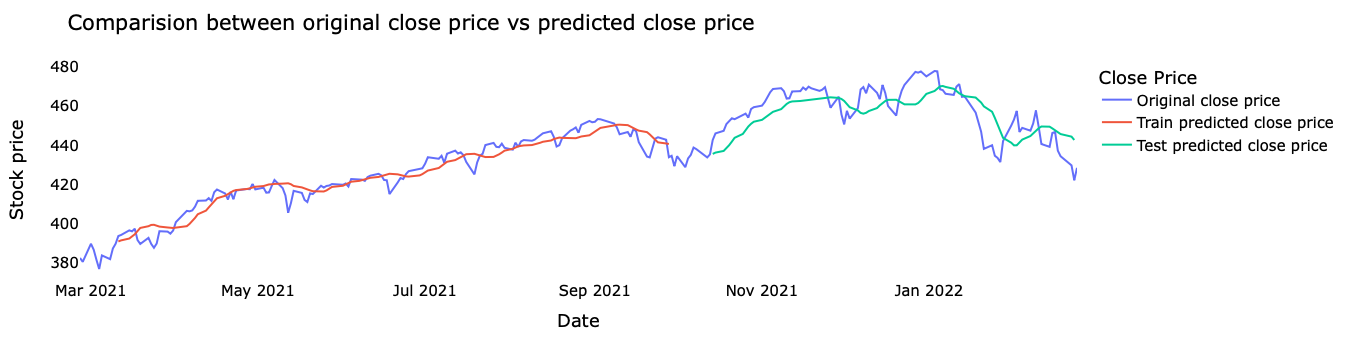

In [31]:
#Comparision of original stock close price and predicted close price
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)


testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [32]:
#Prediction for the next 5 Days
x_input=closedf[len(closedf)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [33]:
#Setting up last 10 days and next predicted 10 days
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17 18 19 20]


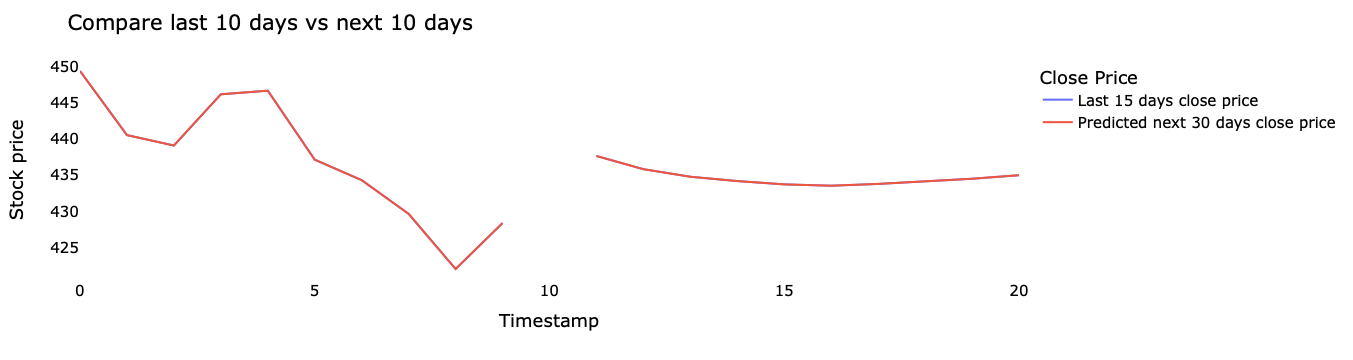

In [34]:
#Plotting out Prediction
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 10 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

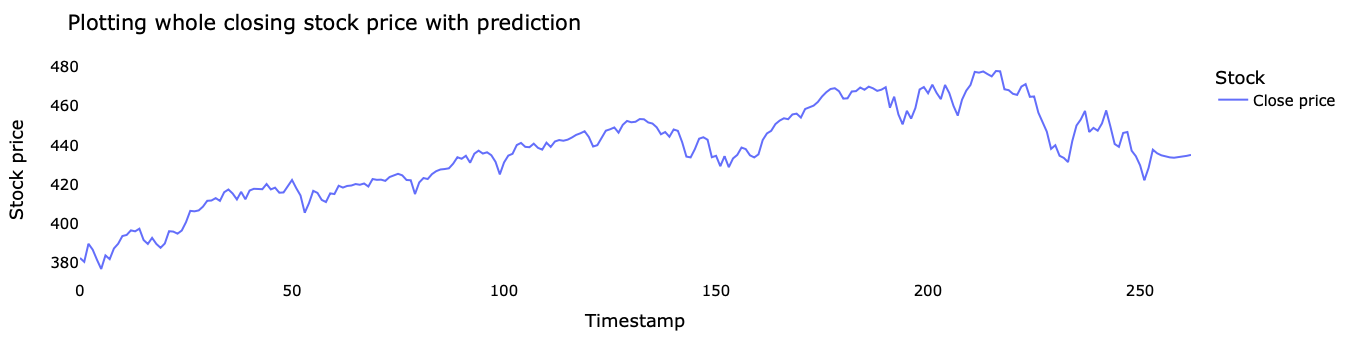

In [35]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()